In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL, evaluate_metrics

from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit

In [5]:
#hyperparameters

#predictive model
layerwidth=20
nblayers=4
activation=nn.ReLU()

#generative model
lat_dim=5



#optimizer
learning_rate=0.005

#scheduler
patience=25
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=1000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=100 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



In [6]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

# Setup #

In [7]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='foong' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

sigma_noise=setup.sigma_noise
print(sigma_noise)
sigma_prior=1.#setup.sigma_prior    

size_data=len(train_dataset)
#batch_size
batch_size=30


n_samples_FU=30 #number of OOD inputs for evaluation of the KL in predictor space
n_train_input_samples_KL=0 #must be lower or equal to batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

0.1


# Predictive model #

In [8]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

print('input dim: '+str(input_dim))
print('param count: '+str(param_count))

input dim: 1
param count: 1321


# ELBO

## Average Log Likelihood

In [9]:
#average log likelihood loss
def loss(x_data, y_data, GeN):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """

    y_pred=model(x_data,GeN(n_samples_LL))
    log_proba=NormalLogLikelihood(y_pred, y_data, sigma_noise).sum(1)
    return log_proba.mean()

## Kullback-Leibler divergence in Predictor space

In [10]:

# sampling of OOD inputs on which evaluate predictors for the Hilbert distance
"""
##for toy example
n_samples_FU=30
def projection(theta0,theta1):
    #batch sample OOD    
    M=2.
    m=-2.
    X_ood = torch.rand(n_samples_FU,input_dim).to(device) * (M-m) + m    
    X=X_ood
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj
"""
#predictor space KL
def projection(theta0,theta1, x_data):
    #batch sample OOD   
    n_ood=n_samples_FU
#    epsilon=0.1
    M = 2.#x_train.max(0, keepdim=True)[0]+epsilon
    m = -2.#x_train.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=torch.cat([X_ood,x_data[:n_train_input_samples_KL,:]])
    
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj

def projection_train(theta0,theta1,x_data):
    #batch sample OOD

    #compute projection on both paramters with model
    theta0_proj=model(x_data, theta0).squeeze(2)
    theta1_proj=model(x_data, theta1).squeeze(2)
    return theta0_proj, theta1_proj


#prior on parameters of predictive model

def prior(n):
    return sigma_prior*torch.randn(size=(n,param_count), device=device)


def kl(x_data, GeN, beta=1.):

    theta=GeN(n_samples_KL) #variationnel
    theta_prior=prior(n_samples_KL) #prior

    theta_proj, theta_prior_proj = projection(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device,beta=beta)
    return K

def kl_train(GeN,x_data):

    theta=GeN(x_data.shape[0]) #variationnel
    theta_prior=prior(x_data.shape[0]) #prior

    theta_proj, theta_prior_proj = projection_train(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K

models_HMC = torch.load('Results/HMC_models.pt')
HMC=models_HMC[dataset][:500,:].to(device)
def kl_HMC_train(GeN,x_data):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection_train(theta, HMC ,x_data)

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

def kl_HMC_OOD(GeN):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection(theta, HMC, torch.empty((0,input_dim)).to(device))

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

In [11]:
def meanlogKNNdistance(sample,k):
    distances= torch.cdist(sample, sample, p=2)
    kNN = torch.topk(distances, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf
    return kNN.log().mean()
meanNNs=[]
for (x,y) in train_loader:
    sample=prior(n_samples_KL)
    prior_pred,_=projection(sample,sample,x)
    meanNNs.append(meanlogKNNdistance(prior_pred,k=1).item())
print(np.mean(meanNNs))

4.7379478216171265


## ELBO ##

In [14]:
#ELBO

beta=1.
def ELBO(x_data, y_data, GeN, beta=beta):
    alpha=(len(x_data)/size_data)
    Average_LogLikelihood=loss(x_data, y_data, GeN)
    the_KL=kl(x_data, GeN, beta)
    the_ELBO= - Average_LogLikelihood+ alpha*the_KL
    return the_ELBO, the_KL, Average_LogLikelihood 


# Generative model #

In [15]:
#generative model
GeN = BigGenerator(lat_dim,param_count,device).to(device)
print(GeN)

BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=1321, bias=True)
  )
)


# Optimizer

In [16]:
optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)

Run=IVI(train_loader, ELBO, optimizer)

# Scheduler #

In [17]:
#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [20]:
KLs=[]
ELBOs=[]
LLs=[]
LRs=[]

test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[],
              'WAIC':[]
             }
start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        
        theta=GeN(1000).detach()
        y_pred=model(x_test,theta)
        metrics=evaluate_metrics(y_pred, torch.tensor(sigma_noise).view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
  
        
        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        scores=Run.run(GeN)
        tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'])
        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LLs.append(scores['LL'])
        LRs.append(scores['lr'])
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



 14%|█▍        | 141/1000 [00:20<02:15,  6.36it/s, ELBO=5.19, KL=95.1, LogLike=18.6, lr=0.0025]

Epoch   140: reducing learning rate of group 0 to 2.5000e-03.


 17%|█▋        | 167/1000 [00:24<02:13,  6.24it/s, ELBO=-4.2, KL=82.4, LogLike=24.8, lr=0.00125] 

Epoch   166: reducing learning rate of group 0 to 1.2500e-03.


 19%|█▉        | 193/1000 [00:28<02:15,  5.94it/s, ELBO=-7.4, KL=73.7, LogLike=25.8, lr=0.000625]

Epoch   192: reducing learning rate of group 0 to 6.2500e-04.


 22%|██▏       | 219/1000 [00:33<02:02,  6.37it/s, ELBO=-7.6, KL=74.8, LogLike=26.3, lr=0.000313] 

Epoch   218: reducing learning rate of group 0 to 3.1250e-04.


 24%|██▍       | 245/1000 [00:37<01:55,  6.52it/s, ELBO=-7.27, KL=76, LogLike=26.3, lr=0.000156]  

Epoch   244: reducing learning rate of group 0 to 1.5625e-04.


 27%|██▋       | 270/1000 [00:41<01:51,  6.53it/s, ELBO=-8.21, KL=72.4, LogLike=26.3, lr=0.0001]  

Epoch   270: reducing learning rate of group 0 to 1.0000e-04.


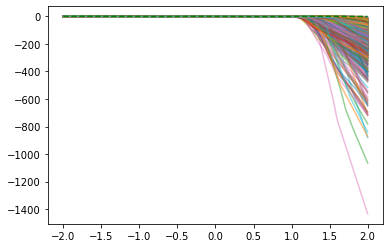

In [23]:
inputs=torch.linspace(-2.,2.,500).unsqueeze(-1).to(device)
for _ in range(1000):
    f=model(inputs,GeN(1)).squeeze().detach().cpu()
    plt.plot(inputs.cpu(),model(inputs,GeN(1)).squeeze().detach().cpu(),alpha=0.5)
plt.plot(inputs.cpu(), torch.cos(4.0*(inputs+0.2)).cpu(),'--',color='green')


In [21]:
%matplotlib inline
fig=setup.makePlotCI(GeN(1000).detach(),device,sigma_noise)
ax=fig.get_axes()[0]
linspace=torch.linspace(-2,2,200)
ax.plot(linspace, torch.cos(4.0*(linspace+0.2)),'--',color='green')


RuntimeError: split_with_sizes expects split_sizes to sum exactly to 1321 (input tensor's size at dimension 1), but got split_sizes=[50, 50, 50, 1]

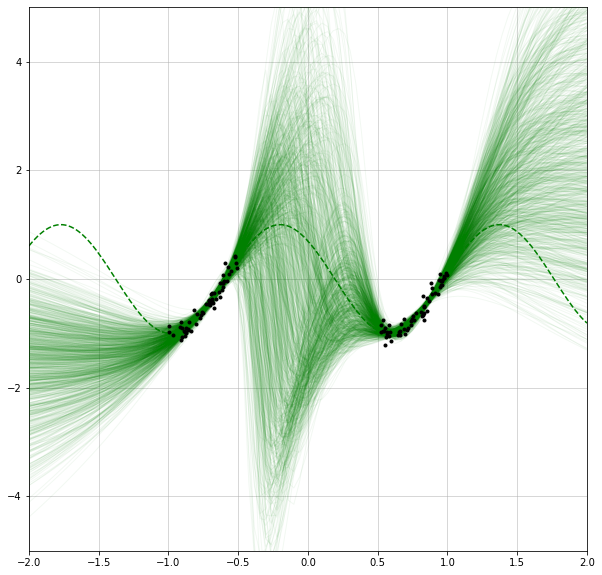

In [24]:
%matplotlib inline
fig=setup.makePlot(GeN(1000).detach(),device)
ax=fig.get_axes()[0]
linspace=torch.linspace(-2,2,200)
ax.plot(linspace, torch.cos(4.0*(linspace+0.2)),'--', color='green')


# Results on test #

In [77]:
#compute metrics on test

results={}
log_device='cpu'
theta=GeN(2000).detach()
metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu')
results.update({dataset:metrics})
results[dataset].update({'time [s]':execution_time})

print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

foong
RMSE: (1.159155011177063, 1.5649124383926392)
LPP: (-1.4439219236373901, 2.3569235801696777)
PICP: 0.7633333206176758
MPIW: 2.3977551460266113
time [s]: 85.20342182193417


In [78]:
#compute metrics on test

results={}
log_device='cpu'
theta=prior(2000).detach()
metrics_=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu')
results.update({dataset:metrics_})

print(dataset)
print("prior's scores")
for m, r in metrics_.items():
    print(m+': '+str(r))

foong
prior's scores
RMSE: (0.7111519575119019, 0.6389871835708618)
LPP: (-2.542259693145752, 0.15891346335411072)
PICP: 1.0
MPIW: 20.119436264038086


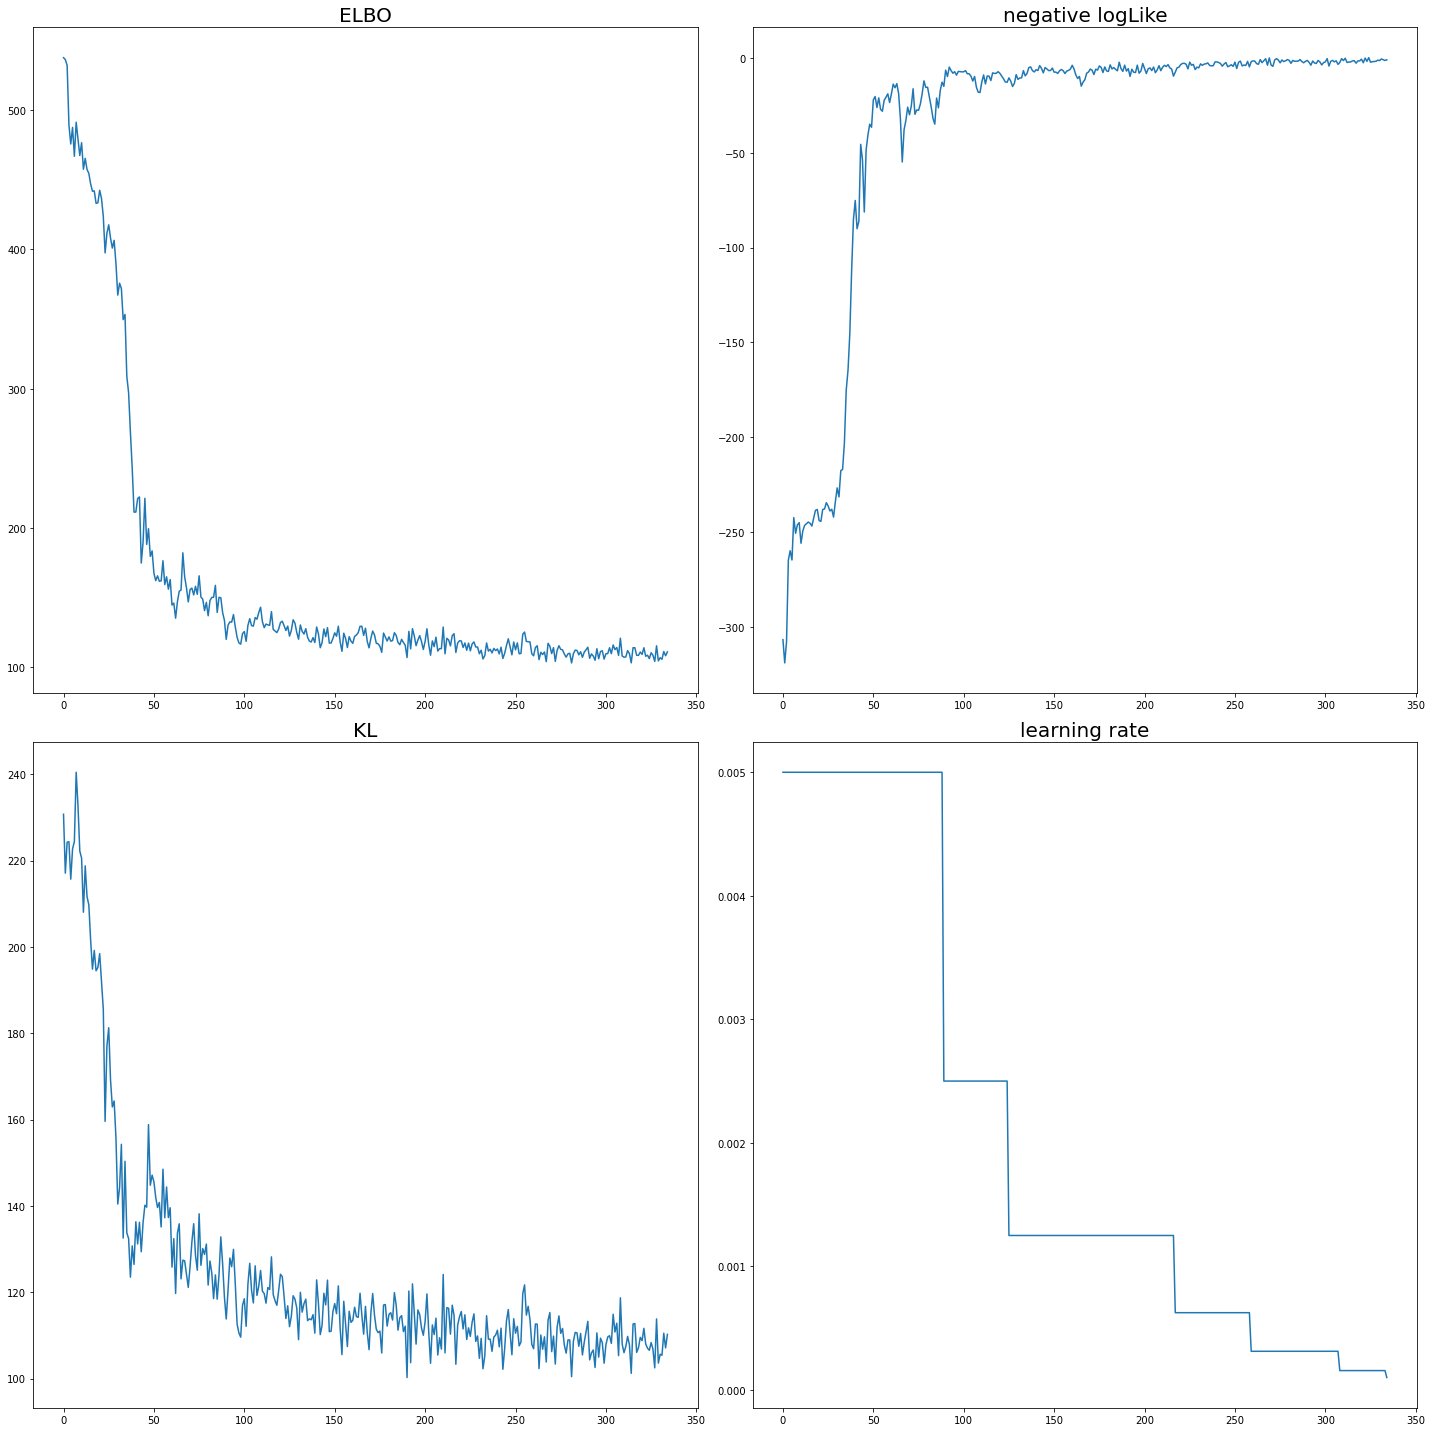

In [79]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs, 'LL':LLs}
time_line=torch.arange(0,len(training['ELBO']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LR_=torch.as_tensor(training['LR'])
LL_=torch.as_tensor(training['LL'])

fig, ax =plt.subplots(2,2, figsize=(20,20))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,LL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)
fig.tight_layout()

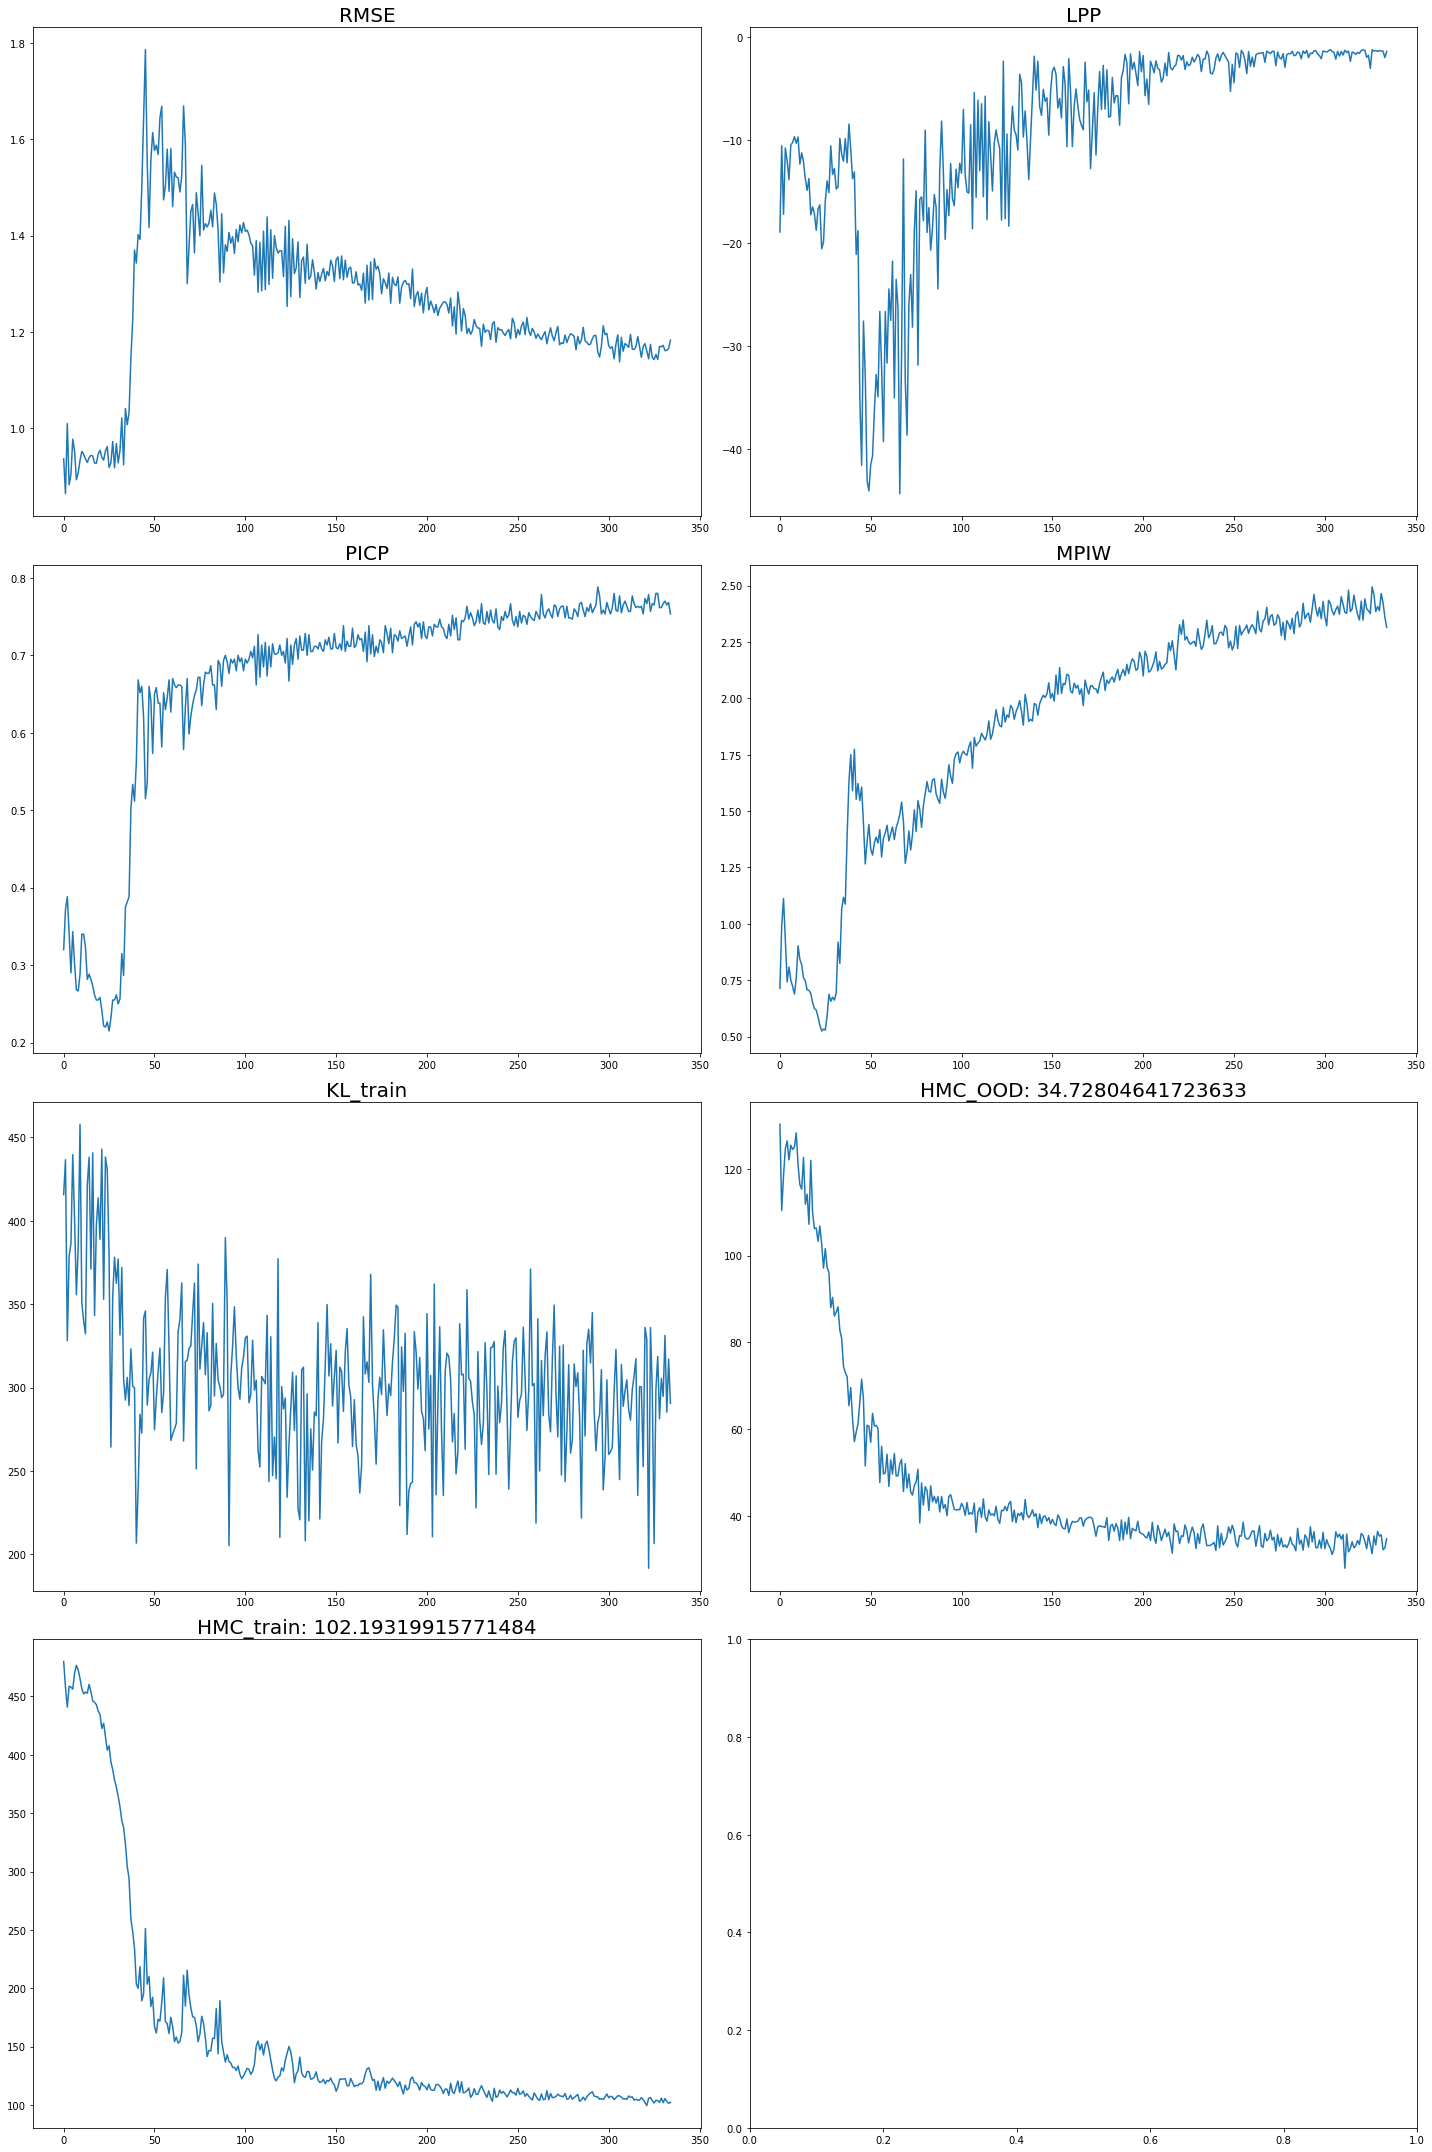

In [80]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(4,2, figsize=(20,30))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
m='KL_train'
ax[2,0].plot(time_line,test_metrics[m])
ax[2,0].set_title(m, fontsize=20)
m='HMC_OOD'
ax[2,1].plot(time_line,test_metrics[m])
ax[2,1].set_title(m+': '+str(test_metrics[m][-1].item()), fontsize=20)
m='HMC_train'
ax[3,0].plot(time_line,test_metrics[m])
ax[3,0].set_title(m+': '+str(test_metrics[m][-1].item()), fontsize=20)
fig.tight_layout()

# Uncertainty vs error #

In [81]:
from torch.distributions import Uniform

sigma_noise_data = torch.tensor(0.1)
N = 25
M=100

X_l=Uniform(torch.tensor([-1.0]), torch.tensor([-.5])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r=Uniform(torch.tensor([.5]), torch.tensor([1.0])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_in=torch.cat([X_l,X_r]).to(device)
X_middle=Uniform(torch.tensor([-.5]), torch.tensor([.5])).sample(sample_shape=torch.Size([int(200)])).squeeze().to(device)
X_l_=Uniform(torch.tensor([-2.0]), torch.tensor([-1.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r_=Uniform(torch.tensor([1.]), torch.tensor([2.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_out=torch.cat([X_l_,X_r_]).to(device)

def f(X):
    y_ = torch.cos(4.0*(X+0.2)) 
    return y_ + sigma_noise_data* torch.randn_like(y_)

y_in=f(X_in).unsqueeze(-1)
y_middle=f(X_middle).unsqueeze(-1)
y_out=f(X_out).unsqueeze(-1)
print(X_in.shape, y_in.shape)

torch.Size([200]) torch.Size([200, 1])


Text(0.5, 0, 'Uncertainty (Diff Entropy)')

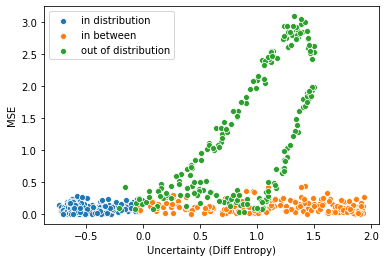

In [82]:
import seaborn as sns

X=[X_in,X_middle,X_out]
y=[y_in,y_middle,y_out]
label=['in distribution', 'in between', 'out of distribution']
def Entropy(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x NbExemples X NbDimensions
        k (Int): ordinal number

    Returns:
        Tensor: H of size Batch x 1, k-Nearest Neighbour Estimation of the entropy of theta, H[b]=H(theta[b]).

    """
    batch=theta.shape[0]
    nb_samples=theta.shape[1]
    d=torch.tensor(theta.shape[-1]).float()
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=1, largest=False, sorted=True)[0][:,k].to(device) #.clamp(torch.finfo().eps,float('inf'))    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    K_MC=torch.as_tensor(float(k_MC), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*torch.log(a).sum(1)


Hs=[]
AEs=[]
for i in range(len(X)):
    theta=GeN(1000).detach()
    pred_=model(X[i],theta)
    pred=pred_+sigma_noise*torch.randn_like(pred_)

    M = pred.shape[0]
    M_low = int(0.025 * M)
    M_high = int(0.975 * M)

    y_pred_s, _ = pred_.sort(dim=0)

    y_low = y_pred_s[M_low, :].squeeze().to(device)
    y_high = y_pred_s[M_high, :].squeeze().to(device)

    PIW=(std_y_train*(y_high-y_low))


    H=(Entropy(pred.transpose(0,1),k=20))
    Hs.append(H)
    
    STD=(pred.std(0).squeeze())
    pred=model(X[i],theta)
    marginal_se=(pred-y[i])**2
    empirical_sqloss=marginal_se.mean()
    MSE=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze())**2)
    L1error=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze()).abs())
    AEs.append(L1error)
    ax=sns.scatterplot(H.cpu().numpy(),L1error.cpu().numpy(), label=label[i])
    
ax.set_ylabel('MSE')
ax.set_xlabel('Uncertainty (Diff Entropy)')



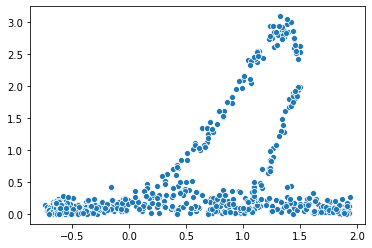

In [83]:
H_=torch.cat(Hs)
AE_=torch.cat(AEs)
sns.scatterplot(H_.cpu(),AE_.cpu())

# grid search beta #

In [14]:

def run(beta,alpha):
    def ELBO(x_data, y_data, GeN, beta=beta, alpha=alpha):
        #alpha=1.#(len(x_data)/size_data)
        Average_LogLikelihood=loss(x_data, y_data, GeN)
        the_KL=kl(x_data, GeN, beta)
        the_ELBO= - Average_LogLikelihood+ alpha*the_KL
        return the_ELBO, the_KL, Average_LogLikelihood 
    GeN = BigGenerator(lat_dim,param_count,device).to(device)
    optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)
    Run=IVI(train_loader, ELBO, optimizer)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=False, min_lr=min_lr)
    
    for t in range(n_epochs):
        scores=Run.run(GeN)
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break

    theta=GeN(2000).detach()
    metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu', std=False)
    meanNNs=[]
    for (x,y) in train_loader:
        sample=GeN(n_samples_KL)
        pred,_=projection(sample,sample,x)
        meanNNs.append(meanlogKNNdistance(pred,k=1).item())
    metrics.update({'meanNN':np.mean(meanNNs),'beta':beta,'alpha':alpha})
    print(metrics)
    return metrics 

    

In [15]:
betas=torch.linspace(0.1,1.,10).numpy()
alphas=torch.linspace(0.1,1.,10).numpy()


gs_results=[]
for i in trange(len(betas)):
    for j in trange(len(alphas)):
#    print(betas[i])
        gs_results.append(run(betas[i],alphas[j]))

    



 10%|█         | 1/10 [00:06<00:54,  6.08s/it]

{'RMSE': 0.9408355355262756, 'LPP': -39.481483570206926, 'PICP': 0.029999999329447746, 'MPIW': 0.06925027072429657, 'meanNN': -inf, 'beta': 0.1, 'alpha': 0.1}



 20%|██        | 2/10 [00:21<01:12,  9.00s/it]

{'RMSE': 1.476425290107727, 'LPP': -79.57968120331233, 'PICP': 0.3866666555404663, 'MPIW': 0.6008892059326172, 'meanNN': -1.8867331743240356, 'beta': 0.1, 'alpha': 0.19999999}



 30%|███       | 3/10 [00:38<01:18, 11.16s/it]

{'RMSE': 1.4135700464248657, 'LPP': -68.94408400622703, 'PICP': 0.1966666728258133, 'MPIW': 0.3476431369781494, 'meanNN': -2.0999444127082825, 'beta': 0.1, 'alpha': 0.29999998}



 40%|████      | 4/10 [00:52<01:12, 12.03s/it]

{'RMSE': 1.3502238988876343, 'LPP': -61.88515346159082, 'PICP': 0.28166666626930237, 'MPIW': 0.458855539560318, 'meanNN': -1.7167405486106873, 'beta': 0.1, 'alpha': 0.39999998}



 50%|█████     | 5/10 [01:06<01:02, 12.59s/it]

{'RMSE': 1.200761318206787, 'LPP': -44.2449097177676, 'PICP': 0.3683333396911621, 'MPIW': 0.46673381328582764, 'meanNN': -1.7608180046081543, 'beta': 0.1, 'alpha': 0.49999997}



 60%|██████    | 6/10 [01:23<00:56, 14.10s/it]

{'RMSE': 1.3360512256622314, 'LPP': -42.4136638148603, 'PICP': 0.36666667461395264, 'MPIW': 0.7161799073219299, 'meanNN': -1.6085250675678253, 'beta': 0.1, 'alpha': 0.6}



 70%|███████   | 7/10 [01:31<00:36, 12.26s/it]

{'RMSE': 0.9246252179145813, 'LPP': -30.613126093182732, 'PICP': 0.07666666805744171, 'MPIW': 0.21549636125564575, 'meanNN': -2.9410906434059143, 'beta': 0.1, 'alpha': 0.70000005}



 80%|████████  | 8/10 [01:40<00:22, 11.24s/it]

{'RMSE': 0.9609269499778748, 'LPP': -24.56953342191477, 'PICP': 0.17000000178813934, 'MPIW': 0.5742045640945435, 'meanNN': -2.401451826095581, 'beta': 0.1, 'alpha': 0.8}



 90%|█████████ | 9/10 [01:53<00:11, 11.66s/it]

{'RMSE': 1.100059151649475, 'LPP': -13.118630445396413, 'PICP': 0.31833332777023315, 'MPIW': 0.6722216010093689, 'meanNN': -1.3726357519626617, 'beta': 0.1, 'alpha': 0.9}



  0%|          | 0/10 [00:00<?, ?it/s]

{'RMSE': 0.9397701025009155, 'LPP': -27.242860653808883, 'PICP': 0.11666666716337204, 'MPIW': 0.36738139390945435, 'meanNN': -2.431343734264374, 'beta': 0.1, 'alpha': 1.0}



 10%|█         | 1/10 [00:08<01:12,  8.11s/it]

{'RMSE': 0.9382911920547485, 'LPP': -39.12267748352771, 'PICP': 0.036666665226221085, 'MPIW': 0.08647292107343674, 'meanNN': -3.838244676589966, 'beta': 0.19999999, 'alpha': 0.1}



 20%|██        | 2/10 [00:25<01:27, 10.98s/it]

{'RMSE': 1.5548237562179565, 'LPP': -78.39055449320462, 'PICP': 0.20999999344348907, 'MPIW': 0.49704498052597046, 'meanNN': -1.7291864454746246, 'beta': 0.19999999, 'alpha': 0.19999999}



 30%|███       | 3/10 [00:43<01:30, 12.87s/it]

{'RMSE': 1.4429582357406616, 'LPP': -51.94160893939969, 'PICP': 0.2866666615009308, 'MPIW': 0.6095759868621826, 'meanNN': -1.47096186876297, 'beta': 0.19999999, 'alpha': 0.29999998}



 40%|████      | 4/10 [00:58<01:22, 13.70s/it]

{'RMSE': 1.4098116159439087, 'LPP': -56.55109987592291, 'PICP': 0.4050000011920929, 'MPIW': 0.5819230079650879, 'meanNN': -1.5433302521705627, 'beta': 0.19999999, 'alpha': 0.39999998}



 50%|█████     | 5/10 [01:16<01:14, 14.80s/it]

{'RMSE': 1.1080105304718018, 'LPP': -18.919002518301497, 'PICP': 0.5199999809265137, 'MPIW': 0.9040191769599915, 'meanNN': -1.2173633575439453, 'beta': 0.19999999, 'alpha': 0.49999997}



 60%|██████    | 6/10 [01:34<01:03, 15.79s/it]

{'RMSE': 1.0807578563690186, 'LPP': -26.501071287609157, 'PICP': 0.4749999940395355, 'MPIW': 0.8595842719078064, 'meanNN': -1.183038353919983, 'beta': 0.19999999, 'alpha': 0.6}



 70%|███████   | 7/10 [01:48<00:45, 15.27s/it]

{'RMSE': 1.1431689262390137, 'LPP': -25.400442310423045, 'PICP': 0.4350000023841858, 'MPIW': 0.8955711126327515, 'meanNN': -1.0839071869850159, 'beta': 0.19999999, 'alpha': 0.70000005}



 80%|████████  | 8/10 [02:06<00:32, 16.15s/it]

{'RMSE': 1.0433011054992676, 'LPP': -11.480210440268875, 'PICP': 0.46833333373069763, 'MPIW': 0.9673448801040649, 'meanNN': -0.9653895050287247, 'beta': 0.19999999, 'alpha': 0.8}



 90%|█████████ | 9/10 [02:19<00:15, 15.11s/it]

{'RMSE': 0.9014386534690857, 'LPP': -8.237685113375408, 'PICP': 0.3266666531562805, 'MPIW': 0.6858618259429932, 'meanNN': -1.1074113547801971, 'beta': 0.19999999, 'alpha': 0.9}



  0%|          | 0/10 [00:00<?, ?it/s]

{'RMSE': 1.070124626159668, 'LPP': -17.73478242331702, 'PICP': 0.41999998688697815, 'MPIW': 0.9036689400672913, 'meanNN': -1.0286999940872192, 'beta': 0.19999999, 'alpha': 1.0}



 10%|█         | 1/10 [00:17<02:34, 17.16s/it]

{'RMSE': 1.6225966215133667, 'LPP': -82.54078837987487, 'PICP': 0.17000000178813934, 'MPIW': 0.37792786955833435, 'meanNN': -1.92073592543602, 'beta': 0.29999998, 'alpha': 0.1}



 20%|██        | 2/10 [00:33<02:15, 16.98s/it]

{'RMSE': 1.4882773160934448, 'LPP': -50.99644629248795, 'PICP': 0.2916666567325592, 'MPIW': 0.67661052942276, 'meanNN': -1.4496680200099945, 'beta': 0.29999998, 'alpha': 0.19999999}



 30%|███       | 3/10 [00:47<01:53, 16.16s/it]

{'RMSE': 1.454954743385315, 'LPP': -37.1745594616825, 'PICP': 0.3766666650772095, 'MPIW': 0.7937209606170654, 'meanNN': -1.2341660559177399, 'beta': 0.29999998, 'alpha': 0.29999998}



 40%|████      | 4/10 [01:07<01:43, 17.18s/it]

{'RMSE': 1.030550479888916, 'LPP': -16.49524781077516, 'PICP': 0.39500001072883606, 'MPIW': 0.849280595779419, 'meanNN': -1.1998421549797058, 'beta': 0.29999998, 'alpha': 0.39999998}



 50%|█████     | 5/10 [01:22<01:22, 16.43s/it]

{'RMSE': 1.2096644639968872, 'LPP': -27.603635511371554, 'PICP': 0.4883333444595337, 'MPIW': 0.99945467710495, 'meanNN': -1.046350210905075, 'beta': 0.29999998, 'alpha': 0.49999997}



 60%|██████    | 6/10 [01:42<01:10, 17.55s/it]

{'RMSE': 0.9124358892440796, 'LPP': -2.1050010652578335, 'PICP': 0.5733333230018616, 'MPIW': 1.2138689756393433, 'meanNN': -0.8273776173591614, 'beta': 0.29999998, 'alpha': 0.6}



 70%|███████   | 7/10 [01:58<00:51, 17.18s/it]

{'RMSE': 1.1583224534988403, 'LPP': -18.204942850173897, 'PICP': 0.503333330154419, 'MPIW': 1.1232441663742065, 'meanNN': -0.842813178896904, 'beta': 0.29999998, 'alpha': 0.70000005}



 80%|████████  | 8/10 [02:20<00:37, 18.56s/it]

{'RMSE': 0.6249938011169434, 'LPP': -0.9368516936844484, 'PICP': 0.6783333420753479, 'MPIW': 1.0939005613327026, 'meanNN': -0.8367351591587067, 'beta': 0.29999998, 'alpha': 0.8}



 90%|█████████ | 9/10 [02:39<00:18, 18.60s/it]

{'RMSE': 0.7860110402107239, 'LPP': -2.3909304943552643, 'PICP': 0.5849999785423279, 'MPIW': 1.0695644617080688, 'meanNN': -0.8744034171104431, 'beta': 0.29999998, 'alpha': 0.9}



  0%|          | 0/10 [00:00<?, ?it/s]

{'RMSE': 0.9152494668960571, 'LPP': -7.300725778478365, 'PICP': 0.5116666555404663, 'MPIW': 0.9450846314430237, 'meanNN': -0.8754980713129044, 'beta': 0.29999998, 'alpha': 1.0}



 10%|█         | 1/10 [00:20<03:04, 20.53s/it]

{'RMSE': 1.568416714668274, 'LPP': -66.78821185564402, 'PICP': 0.29499998688697815, 'MPIW': 0.5466994047164917, 'meanNN': -1.626185268163681, 'beta': 0.39999998, 'alpha': 0.1}



 20%|██        | 2/10 [00:38<02:39, 19.91s/it]

{'RMSE': 1.343213438987732, 'LPP': -32.854624179528074, 'PICP': 0.3100000023841858, 'MPIW': 0.7189732789993286, 'meanNN': -1.3044187724590302, 'beta': 0.39999998, 'alpha': 0.19999999}



 30%|███       | 3/10 [00:55<02:11, 18.79s/it]

{'RMSE': 1.3189886808395386, 'LPP': -21.296985207382306, 'PICP': 0.39666667580604553, 'MPIW': 0.8771851658821106, 'meanNN': -1.1609985828399658, 'beta': 0.39999998, 'alpha': 0.29999998}



 40%|████      | 4/10 [01:08<01:42, 17.04s/it]

{'RMSE': 1.3744723796844482, 'LPP': -27.425164167933314, 'PICP': 0.5433333516120911, 'MPIW': 1.1364425420761108, 'meanNN': -0.9602732360363007, 'beta': 0.39999998, 'alpha': 0.39999998}



 50%|█████     | 5/10 [01:22<01:20, 16.11s/it]

{'RMSE': 0.7706749439239502, 'LPP': -2.670749065621346, 'PICP': 0.653333306312561, 'MPIW': 1.0427013635635376, 'meanNN': -0.9483951926231384, 'beta': 0.39999998, 'alpha': 0.49999997}



 60%|██████    | 6/10 [01:37<01:04, 16.05s/it]

{'RMSE': 1.0813053846359253, 'LPP': -12.293362183674157, 'PICP': 0.5833333134651184, 'MPIW': 1.2554149627685547, 'meanNN': -0.7498846501111984, 'beta': 0.39999998, 'alpha': 0.6}



 70%|███████   | 7/10 [01:57<00:50, 16.99s/it]

{'RMSE': 0.8828834891319275, 'LPP': -3.9046634210117244, 'PICP': 0.6483333110809326, 'MPIW': 1.3296303749084473, 'meanNN': -0.7233141958713531, 'beta': 0.39999998, 'alpha': 0.70000005}



 80%|████████  | 8/10 [02:12<00:32, 16.47s/it]

{'RMSE': 0.9151029586791992, 'LPP': -3.904011348091869, 'PICP': 0.5366666913032532, 'MPIW': 1.1056078672409058, 'meanNN': -0.6549767553806305, 'beta': 0.39999998, 'alpha': 0.8}



 90%|█████████ | 9/10 [02:31<00:17, 17.26s/it]

{'RMSE': 0.7307665944099426, 'LPP': -1.126827484980167, 'PICP': 0.7133333086967468, 'MPIW': 1.2536647319793701, 'meanNN': -0.6227131932973862, 'beta': 0.39999998, 'alpha': 0.9}



  0%|          | 0/10 [00:00<?, ?it/s]

{'RMSE': 0.9090508222579956, 'LPP': -1.4210359598110167, 'PICP': 0.5833333134651184, 'MPIW': 1.3513805866241455, 'meanNN': -0.5644917339086533, 'beta': 0.39999998, 'alpha': 1.0}



 10%|█         | 1/10 [00:08<01:13,  8.19s/it]

{'RMSE': 0.9327890276908875, 'LPP': -35.445182342639626, 'PICP': 0.04833333194255829, 'MPIW': 0.12813550233840942, 'meanNN': -3.4876821637153625, 'beta': 0.49999997, 'alpha': 0.1}



 20%|██        | 2/10 [00:27<01:31, 11.46s/it]

{'RMSE': 1.4333747625350952, 'LPP': -28.090171473943563, 'PICP': 0.3566666543483734, 'MPIW': 0.9057411551475525, 'meanNN': -1.1842869222164154, 'beta': 0.49999997, 'alpha': 0.19999999}



 30%|███       | 3/10 [00:47<01:38, 14.07s/it]

{'RMSE': 1.100176215171814, 'LPP': -7.4407455990682365, 'PICP': 0.5366666913032532, 'MPIW': 1.2215756177902222, 'meanNN': -0.7741945832967758, 'beta': 0.49999997, 'alpha': 0.29999998}



 40%|████      | 4/10 [01:00<01:22, 13.78s/it]

{'RMSE': 1.3781346082687378, 'LPP': -15.666361330295276, 'PICP': 0.5716666579246521, 'MPIW': 1.2735073566436768, 'meanNN': -0.7233129888772964, 'beta': 0.49999997, 'alpha': 0.39999998}



 50%|█████     | 5/10 [01:15<01:10, 14.02s/it]

{'RMSE': 0.9629641771316528, 'LPP': -6.040755178409585, 'PICP': 0.5899999737739563, 'MPIW': 1.2530639171600342, 'meanNN': -0.8116343319416046, 'beta': 0.49999997, 'alpha': 0.49999997}



 60%|██████    | 6/10 [01:32<01:00, 15.12s/it]

{'RMSE': 0.9495783448219299, 'LPP': -4.584191615310493, 'PICP': 0.5666666626930237, 'MPIW': 1.2321127653121948, 'meanNN': -0.5370426997542381, 'beta': 0.49999997, 'alpha': 0.6}



 70%|███████   | 7/10 [01:46<00:44, 14.84s/it]

{'RMSE': 0.9315463304519653, 'LPP': -4.637634321821912, 'PICP': 0.5799999833106995, 'MPIW': 1.168618083000183, 'meanNN': -0.7045523971319199, 'beta': 0.49999997, 'alpha': 0.70000005}



 80%|████████  | 8/10 [02:08<00:33, 16.85s/it]

{'RMSE': 0.8096019625663757, 'LPP': -1.2930444959448493, 'PICP': 0.6349999904632568, 'MPIW': 1.2922948598861694, 'meanNN': -0.5934887006878853, 'beta': 0.49999997, 'alpha': 0.8}



 90%|█████████ | 9/10 [02:22<00:15, 15.91s/it]

{'RMSE': 0.836161732673645, 'LPP': -1.9921922479334266, 'PICP': 0.6666666865348816, 'MPIW': 1.3723427057266235, 'meanNN': -0.5990119054913521, 'beta': 0.49999997, 'alpha': 0.9}



  0%|          | 0/10 [00:00<?, ?it/s]

{'RMSE': 0.7714428901672363, 'LPP': -2.0472445365368275, 'PICP': 0.7483333349227905, 'MPIW': 1.3463536500930786, 'meanNN': -0.565703846514225, 'beta': 0.49999997, 'alpha': 1.0}



 10%|█         | 1/10 [00:16<02:27, 16.37s/it]

{'RMSE': 1.5600684881210327, 'LPP': -66.21411768147972, 'PICP': 0.24666666984558105, 'MPIW': 0.5870502591133118, 'meanNN': -1.5592094361782074, 'beta': 0.6, 'alpha': 0.1}



 20%|██        | 2/10 [00:32<02:11, 16.40s/it]

{'RMSE': 1.5235486030578613, 'LPP': -23.58302116452435, 'PICP': 0.3583333194255829, 'MPIW': 0.9070851802825928, 'meanNN': -1.0760869085788727, 'beta': 0.6, 'alpha': 0.19999999}



 30%|███       | 3/10 [00:54<02:05, 17.90s/it]

{'RMSE': 0.9132466912269592, 'LPP': -9.308404273140107, 'PICP': 0.57833331823349, 'MPIW': 1.0776159763336182, 'meanNN': -0.6785718351602554, 'beta': 0.6, 'alpha': 0.29999998}



 40%|████      | 4/10 [01:12<01:48, 18.04s/it]

{'RMSE': 0.9434699416160583, 'LPP': -2.699118327441722, 'PICP': 0.6650000214576721, 'MPIW': 1.5339139699935913, 'meanNN': -0.6120744347572327, 'beta': 0.6, 'alpha': 0.39999998}



 50%|█████     | 5/10 [01:34<01:36, 19.23s/it]

{'RMSE': 0.8683919310569763, 'LPP': -1.6833650899245893, 'PICP': 0.6333333253860474, 'MPIW': 1.4025404453277588, 'meanNN': -0.5655485615134239, 'beta': 0.6, 'alpha': 0.49999997}



 60%|██████    | 6/10 [01:47<01:09, 17.44s/it]

{'RMSE': 1.1306254863739014, 'LPP': -8.407675037403346, 'PICP': 0.5933333039283752, 'MPIW': 1.4838097095489502, 'meanNN': -0.5165138095617294, 'beta': 0.6, 'alpha': 0.6}



 70%|███████   | 7/10 [02:05<00:52, 17.35s/it]

{'RMSE': 0.9018719792366028, 'LPP': -2.082833148241329, 'PICP': 0.6483333110809326, 'MPIW': 1.4072904586791992, 'meanNN': -0.48944442719221115, 'beta': 0.6, 'alpha': 0.70000005}



 80%|████████  | 8/10 [02:25<00:36, 18.27s/it]

{'RMSE': 0.7900753021240234, 'LPP': -1.1877507194508825, 'PICP': 0.7133333086967468, 'MPIW': 1.4527531862258911, 'meanNN': -0.474810890853405, 'beta': 0.6, 'alpha': 0.8}



 90%|█████████ | 9/10 [02:43<00:18, 18.33s/it]

{'RMSE': 0.8676641583442688, 'LPP': -1.2560499237853986, 'PICP': 0.6583333611488342, 'MPIW': 1.4811910390853882, 'meanNN': -0.34474655613303185, 'beta': 0.6, 'alpha': 0.9}



  0%|          | 0/10 [00:00<?, ?it/s]

{'RMSE': 0.8199521899223328, 'LPP': -1.0843546875107561, 'PICP': 0.753333330154419, 'MPIW': 1.6453733444213867, 'meanNN': -0.2764492407441139, 'beta': 0.6, 'alpha': 1.0}



 10%|█         | 1/10 [00:19<02:54, 19.39s/it]

{'RMSE': 1.4537816047668457, 'LPP': -43.01508653393892, 'PICP': 0.24833333492279053, 'MPIW': 0.6524829268455505, 'meanNN': -1.3773511052131653, 'beta': 0.70000005, 'alpha': 0.1}



 20%|██        | 2/10 [00:36<02:29, 18.74s/it]

{'RMSE': 1.3369548320770264, 'LPP': -22.914014963656083, 'PICP': 0.41499999165534973, 'MPIW': 1.0860874652862549, 'meanNN': -0.8874226063489914, 'beta': 0.70000005, 'alpha': 0.19999999}



 30%|███       | 3/10 [00:54<02:09, 18.46s/it]

{'RMSE': 1.075476050376892, 'LPP': -8.887087819012335, 'PICP': 0.6200000047683716, 'MPIW': 1.4485642910003662, 'meanNN': -0.6074560880661011, 'beta': 0.70000005, 'alpha': 0.29999998}



 40%|████      | 4/10 [01:16<01:58, 19.70s/it]

{'RMSE': 0.8236770629882812, 'LPP': -1.8419749093386004, 'PICP': 0.6449999809265137, 'MPIW': 1.4446501731872559, 'meanNN': -0.469132736325264, 'beta': 0.70000005, 'alpha': 0.39999998}



 50%|█████     | 5/10 [01:39<01:42, 20.50s/it]

{'RMSE': 0.8262659311294556, 'LPP': -1.0116683377880398, 'PICP': 0.6949999928474426, 'MPIW': 1.591462254524231, 'meanNN': -0.4611809775233269, 'beta': 0.70000005, 'alpha': 0.49999997}



 60%|██████    | 6/10 [01:58<01:20, 20.15s/it]

{'RMSE': 0.7431241273880005, 'LPP': -1.0021431062255635, 'PICP': 0.7316666841506958, 'MPIW': 1.6462512016296387, 'meanNN': -0.3445805162191391, 'beta': 0.70000005, 'alpha': 0.6}



 70%|███████   | 7/10 [02:12<00:54, 18.27s/it]

{'RMSE': 1.090616226196289, 'LPP': -3.342933931027436, 'PICP': 0.6399999856948853, 'MPIW': 1.693945288658142, 'meanNN': -0.43694598972797394, 'beta': 0.70000005, 'alpha': 0.70000005}



 80%|████████  | 8/10 [02:34<00:38, 19.31s/it]

{'RMSE': 0.6599774956703186, 'LPP': -0.6797016337008885, 'PICP': 0.8366666436195374, 'MPIW': 1.7515909671783447, 'meanNN': -0.35250788554549217, 'beta': 0.70000005, 'alpha': 0.8}



 90%|█████████ | 9/10 [02:52<00:19, 19.04s/it]

{'RMSE': 0.8074779510498047, 'LPP': -1.1324336233111472, 'PICP': 0.7200000286102295, 'MPIW': 1.8099548816680908, 'meanNN': -0.3180452510714531, 'beta': 0.70000005, 'alpha': 0.9}



  0%|          | 0/10 [00:00<?, ?it/s]

{'RMSE': 0.9616715908050537, 'LPP': -1.3789464828467233, 'PICP': 0.6783333420753479, 'MPIW': 1.8775821924209595, 'meanNN': -0.17612294852733612, 'beta': 0.70000005, 'alpha': 1.0}



 10%|█         | 1/10 [00:15<02:20, 15.61s/it]

{'RMSE': 1.5479997396469116, 'LPP': -48.999770648414525, 'PICP': 0.2933333218097687, 'MPIW': 0.7541540265083313, 'meanNN': -1.3777015507221222, 'beta': 0.8, 'alpha': 0.1}



 20%|██        | 2/10 [00:29<02:01, 15.13s/it]

{'RMSE': 1.4675177335739136, 'LPP': -24.330317721570744, 'PICP': 0.4483333230018616, 'MPIW': 1.165666103363037, 'meanNN': -0.952767014503479, 'beta': 0.8, 'alpha': 0.19999999}



 30%|███       | 3/10 [00:47<01:51, 15.91s/it]

{'RMSE': 1.182759165763855, 'LPP': -12.291099666925405, 'PICP': 0.6066666841506958, 'MPIW': 1.4678784608840942, 'meanNN': -0.6211612373590469, 'beta': 0.8, 'alpha': 0.29999998}



 40%|████      | 4/10 [01:04<01:38, 16.38s/it]

{'RMSE': 0.9273967146873474, 'LPP': -4.3038720058315745, 'PICP': 0.6850000023841858, 'MPIW': 1.5443211793899536, 'meanNN': -0.4924507737159729, 'beta': 0.8, 'alpha': 0.39999998}



 50%|█████     | 5/10 [01:20<01:20, 16.07s/it]

{'RMSE': 1.1710679531097412, 'LPP': -5.937872495675834, 'PICP': 0.6466666460037231, 'MPIW': 1.8470580577850342, 'meanNN': -0.45916934311389923, 'beta': 0.8, 'alpha': 0.49999997}



 60%|██████    | 6/10 [01:32<00:59, 14.80s/it]

{'RMSE': 1.1491284370422363, 'LPP': -6.1008176751797665, 'PICP': 0.6516666412353516, 'MPIW': 1.625335693359375, 'meanNN': -0.5353972837328911, 'beta': 0.8, 'alpha': 0.6}



 70%|███████   | 7/10 [01:48<00:46, 15.33s/it]

{'RMSE': 0.9376657009124756, 'LPP': -1.185688680315491, 'PICP': 0.6966666579246521, 'MPIW': 1.864105463027954, 'meanNN': -0.3644595369696617, 'beta': 0.8, 'alpha': 0.70000005}



 80%|████████  | 8/10 [02:08<00:33, 16.68s/it]

{'RMSE': 0.8138008117675781, 'LPP': -0.8858202511752192, 'PICP': 0.8083333373069763, 'MPIW': 2.1649093627929688, 'meanNN': -0.15483980812132359, 'beta': 0.8, 'alpha': 0.8}



 90%|█████████ | 9/10 [02:26<00:17, 17.12s/it]

{'RMSE': 0.7450231909751892, 'LPP': -0.905011613774869, 'PICP': 0.7883333563804626, 'MPIW': 1.579839825630188, 'meanNN': -0.2696341872215271, 'beta': 0.8, 'alpha': 0.9}



  0%|          | 0/10 [00:00<?, ?it/s]

{'RMSE': 0.7671481966972351, 'LPP': -0.9365496017038983, 'PICP': 0.8100000023841858, 'MPIW': 1.9091367721557617, 'meanNN': -0.22953224554657936, 'beta': 0.8, 'alpha': 1.0}



 10%|█         | 1/10 [00:18<02:46, 18.54s/it]

{'RMSE': 1.4623240232467651, 'LPP': -28.72311646535795, 'PICP': 0.3216666579246521, 'MPIW': 0.9120423197746277, 'meanNN': -1.2116763591766357, 'beta': 0.9, 'alpha': 0.1}



 20%|██        | 2/10 [00:36<02:26, 18.26s/it]

{'RMSE': 1.4621185064315796, 'LPP': -12.265050812663457, 'PICP': 0.4216666519641876, 'MPIW': 1.1923218965530396, 'meanNN': -0.8722845762968063, 'beta': 0.9, 'alpha': 0.19999999}



 30%|███       | 3/10 [00:52<02:03, 17.65s/it]

{'RMSE': 1.4396388530731201, 'LPP': -30.71902807264539, 'PICP': 0.5849999785423279, 'MPIW': 1.3889223337173462, 'meanNN': -0.6983836144208908, 'beta': 0.9, 'alpha': 0.29999998}



 40%|████      | 4/10 [01:11<01:48, 18.12s/it]

{'RMSE': 0.9399460554122925, 'LPP': -2.7822098504126984, 'PICP': 0.6949999928474426, 'MPIW': 1.8344584703445435, 'meanNN': -0.20952266454696655, 'beta': 0.9, 'alpha': 0.39999998}



 50%|█████     | 5/10 [01:34<01:37, 19.51s/it]

{'RMSE': 0.8761147260665894, 'LPP': -1.0110059744439859, 'PICP': 0.7283333539962769, 'MPIW': 2.1383354663848877, 'meanNN': -0.029455000534653664, 'beta': 0.9, 'alpha': 0.49999997}



 60%|██████    | 6/10 [01:49<01:12, 18.12s/it]

{'RMSE': 1.2658747434616089, 'LPP': -9.638791434929859, 'PICP': 0.6466666460037231, 'MPIW': 1.8277862071990967, 'meanNN': -0.3733944706618786, 'beta': 0.9, 'alpha': 0.6}



 70%|███████   | 7/10 [02:04<00:52, 17.37s/it]

{'RMSE': 1.1053729057312012, 'LPP': -2.315693356975404, 'PICP': 0.6933333277702332, 'MPIW': 2.0032410621643066, 'meanNN': -0.2808855101466179, 'beta': 0.9, 'alpha': 0.70000005}



 80%|████████  | 8/10 [02:28<00:38, 19.16s/it]

{'RMSE': 0.9304569363594055, 'LPP': -1.0825642325219387, 'PICP': 0.7616666555404663, 'MPIW': 2.0993258953094482, 'meanNN': -0.22398658655583858, 'beta': 0.9, 'alpha': 0.8}



 90%|█████████ | 9/10 [02:50<00:20, 20.11s/it]

{'RMSE': 0.6980438828468323, 'LPP': -0.7541347613997268, 'PICP': 0.8366666436195374, 'MPIW': 2.0810797214508057, 'meanNN': -0.03499384876340628, 'beta': 0.9, 'alpha': 0.9}



  0%|          | 0/10 [00:00<?, ?it/s]

{'RMSE': 0.7972346544265747, 'LPP': -1.0038846338028078, 'PICP': 0.8083333373069763, 'MPIW': 2.2542622089385986, 'meanNN': -0.07087760069407523, 'beta': 0.9, 'alpha': 1.0}



 10%|█         | 1/10 [00:16<02:32, 16.89s/it]

{'RMSE': 1.5188021659851074, 'LPP': -53.92420801055586, 'PICP': 0.2933333218097687, 'MPIW': 0.7184624671936035, 'meanNN': -1.3695617020130157, 'beta': 1.0, 'alpha': 0.1}



 20%|██        | 2/10 [00:30<02:08, 16.03s/it]

{'RMSE': 1.2934266328811646, 'LPP': -13.92144959586469, 'PICP': 0.4883333444595337, 'MPIW': 1.2213373184204102, 'meanNN': -0.810001939535141, 'beta': 1.0, 'alpha': 0.19999999}



 30%|███       | 3/10 [00:44<01:46, 15.21s/it]

{'RMSE': 1.2658709287643433, 'LPP': -10.789624798911278, 'PICP': 0.6183333396911621, 'MPIW': 1.6497527360916138, 'meanNN': -0.5653617978096008, 'beta': 1.0, 'alpha': 0.29999998}



 40%|████      | 4/10 [00:57<01:28, 14.76s/it]

{'RMSE': 1.370988130569458, 'LPP': -24.33971204957142, 'PICP': 0.6150000095367432, 'MPIW': 1.7076528072357178, 'meanNN': -0.5088160485029221, 'beta': 1.0, 'alpha': 0.39999998}



 50%|█████     | 5/10 [01:13<01:15, 15.11s/it]

{'RMSE': 1.186862587928772, 'LPP': -4.216192240993056, 'PICP': 0.6816666722297668, 'MPIW': 1.8623390197753906, 'meanNN': -0.4193498268723488, 'beta': 1.0, 'alpha': 0.49999997}



 60%|██████    | 6/10 [01:40<01:14, 18.50s/it]

{'RMSE': 0.7996296882629395, 'LPP': -0.7423737620963393, 'PICP': 0.8450000286102295, 'MPIW': 2.379798412322998, 'meanNN': -0.06412111036479473, 'beta': 1.0, 'alpha': 0.6}



 70%|███████   | 7/10 [01:59<00:56, 18.86s/it]

{'RMSE': 0.7380965352058411, 'LPP': -0.7399389214367305, 'PICP': 0.8483333587646484, 'MPIW': 2.072638988494873, 'meanNN': -0.2232177834957838, 'beta': 1.0, 'alpha': 0.70000005}



 80%|████████  | 8/10 [02:22<00:39, 19.92s/it]

{'RMSE': 0.6892009377479553, 'LPP': -0.6018869415259988, 'PICP': 0.9350000023841858, 'MPIW': 2.802644968032837, 'meanNN': 0.27782106399536133, 'beta': 1.0, 'alpha': 0.8}



 90%|█████████ | 9/10 [02:39<00:19, 19.19s/it]

{'RMSE': 0.7862741947174072, 'LPP': -0.8659443278828439, 'PICP': 0.8550000190734863, 'MPIW': 2.271435022354126, 'meanNN': -0.11467829532921314, 'beta': 1.0, 'alpha': 0.9}



100%|██████████| 10/10 [27:55<00:00, 167.52s/it]

{'RMSE': 0.7051423788070679, 'LPP': -0.7058836400522227, 'PICP': 0.9616666436195374, 'MPIW': 2.5539631843566895, 'meanNN': 0.07122739404439926, 'beta': 1.0, 'alpha': 1.0}


In [16]:
import pandas as pd
results=pd.DataFrame(gs_results)

,RMSE,LPP,PICP,MPIW,meanNN,beta,alpha
0,0.940836,-39.481484,0.030000,0.069250,-inf,0.1,0.1
1,1.476425,-79.579681,0.386667,0.600889,-1.886733,0.1,0.2
2,1.413570,-68.944084,0.196667,0.347643,-2.099944,0.1,0.3
3,1.350224,-61.885153,0.281667,0.458856,-1.716741,0.1,0.4
4,1.200761,-44.244910,0.368333,0.466734,-1.760818,0.1,0.5
...,...,...,...,...,...,...,...
95,0.799630,-0.742374,0.845000,2.379798,-0.064121,1.0,0.6
96,0.738097,-0.739939,0.848333,2.072639,-0.223218,1.0,0.7
97,0.689201,-0.601887,0.935000,2.802645,0.277821,1.0,0.8
98,0.786274,-0.865944,0.855000,2.271435,-0.114678,1.0,0.9


<Figure size 720x720 with 0 Axes>

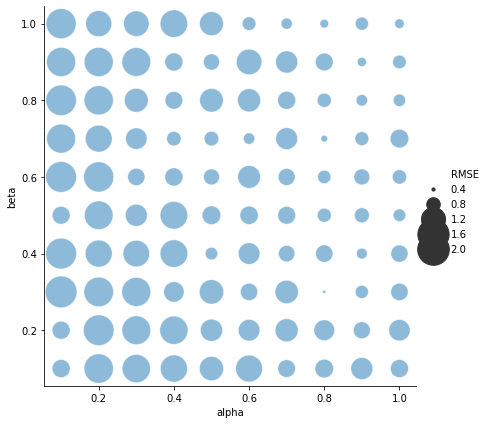

In [29]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.relplot(x="alpha", y="beta", size="RMSE",
            sizes=(10, 1000), alpha=.5, palette="muted",
            height=6, data=results)
results

[Text(0, 0, '0.7'),
 Text(0, 0, '0.72'),
 Text(0, 0, '0.73'),
 Text(0, 0, '0.75'),
 Text(0, 0, '0.76'),
 Text(0, 0, '0.78'),
 Text(0, 0, '0.79'),
 Text(0, 0, '0.81'),
 Text(0, 0, '0.83'),
 Text(0, 0, '0.84'),
 Text(0, 0, '0.86'),
 Text(0, 0, '0.87'),
 Text(0, 0, '0.89'),
 Text(0, 0, '0.91'),
 Text(0, 0, '0.92'),
 Text(0, 0, '0.94'),
 Text(0, 0, '0.95'),
 Text(0, 0, '0.97'),
 Text(0, 0, '0.98'),
 Text(0, 0, '1.0')]

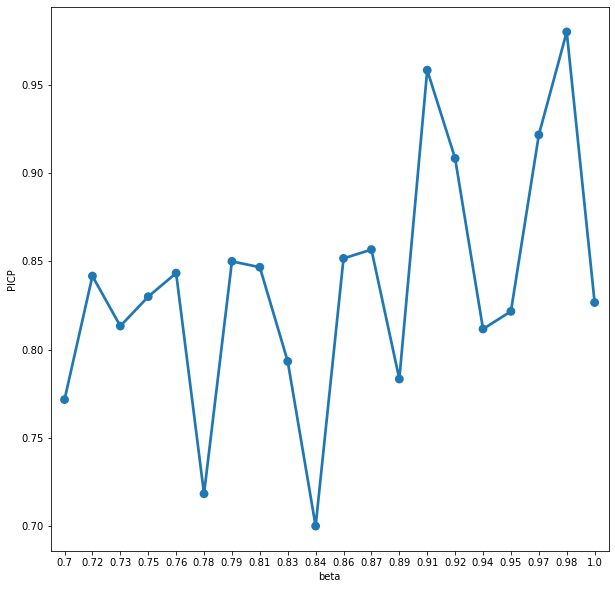

In [263]:
import seaborn as sns
plt.figure(figsize=(10,10))
ax=sns.pointplot('beta','PICP', data=results,ci=None)
#ax=sns.pointplot('beta','MPIW', data=results,ci=None)

xlabels = np.round(betas,2)
ax.set_xticklabels(xlabels)

[Text(0, 0, '0.7'),
 Text(0, 0, '0.72'),
 Text(0, 0, '0.73'),
 Text(0, 0, '0.75'),
 Text(0, 0, '0.76'),
 Text(0, 0, '0.78'),
 Text(0, 0, '0.79'),
 Text(0, 0, '0.81'),
 Text(0, 0, '0.83'),
 Text(0, 0, '0.84'),
 Text(0, 0, '0.86'),
 Text(0, 0, '0.87'),
 Text(0, 0, '0.89'),
 Text(0, 0, '0.91'),
 Text(0, 0, '0.92'),
 Text(0, 0, '0.94'),
 Text(0, 0, '0.95'),
 Text(0, 0, '0.97'),
 Text(0, 0, '0.98'),
 Text(0, 0, '1.0')]

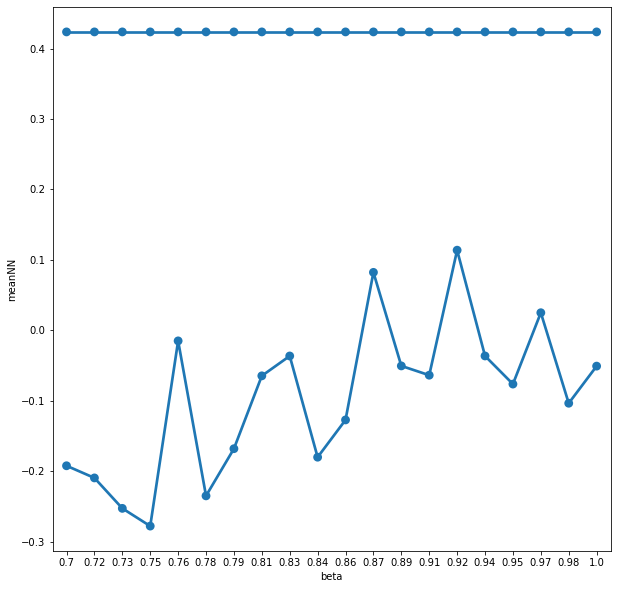

In [264]:
plt.figure(figsize=(10,10))

ax=sns.pointplot('beta','meanNN', data=results,ci=None)
ax=sns.pointplot('beta',0.4236622452735901*torch.ones(len(betas)), data=results,ci=None)
xlabels = np.round(betas,2)
ax.set_xticklabels(xlabels)

[Text(0, 0, '0.7'),
 Text(0, 0, '0.72'),
 Text(0, 0, '0.73'),
 Text(0, 0, '0.75'),
 Text(0, 0, '0.76'),
 Text(0, 0, '0.78'),
 Text(0, 0, '0.79'),
 Text(0, 0, '0.81'),
 Text(0, 0, '0.83'),
 Text(0, 0, '0.84'),
 Text(0, 0, '0.86'),
 Text(0, 0, '0.87'),
 Text(0, 0, '0.89'),
 Text(0, 0, '0.91'),
 Text(0, 0, '0.92'),
 Text(0, 0, '0.94'),
 Text(0, 0, '0.95'),
 Text(0, 0, '0.97'),
 Text(0, 0, '0.98'),
 Text(0, 0, '1.0')]

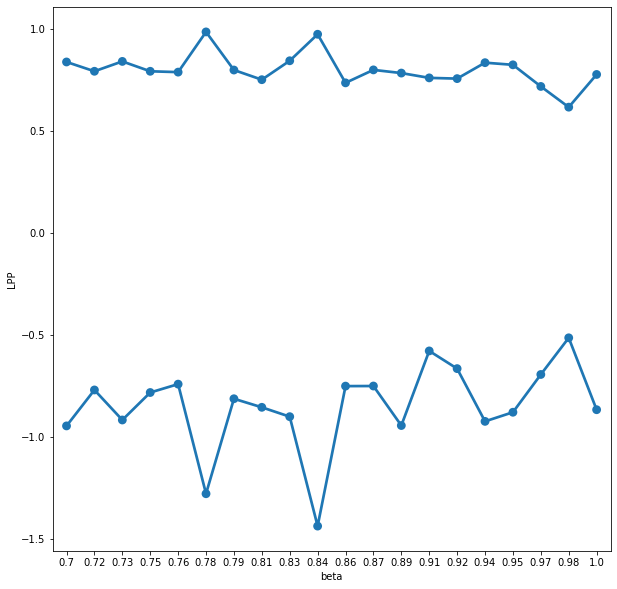

In [265]:
import seaborn as sns
plt.figure(figsize=(10,10))
ax=sns.pointplot('beta','RMSE', data=results,ci=None)
ax=sns.pointplot('beta','LPP', data=results,ci=None)
xlabels = np.round(betas,2)
ax.set_xticklabels(xlabels)

[Text(0, 0, '0.7'),
 Text(0, 0, '0.72'),
 Text(0, 0, '0.73'),
 Text(0, 0, '0.75'),
 Text(0, 0, '0.76'),
 Text(0, 0, '0.78'),
 Text(0, 0, '0.79'),
 Text(0, 0, '0.81'),
 Text(0, 0, '0.83'),
 Text(0, 0, '0.84'),
 Text(0, 0, '0.86'),
 Text(0, 0, '0.87'),
 Text(0, 0, '0.89'),
 Text(0, 0, '0.91'),
 Text(0, 0, '0.92'),
 Text(0, 0, '0.94'),
 Text(0, 0, '0.95'),
 Text(0, 0, '0.97'),
 Text(0, 0, '0.98'),
 Text(0, 0, '1.0')]

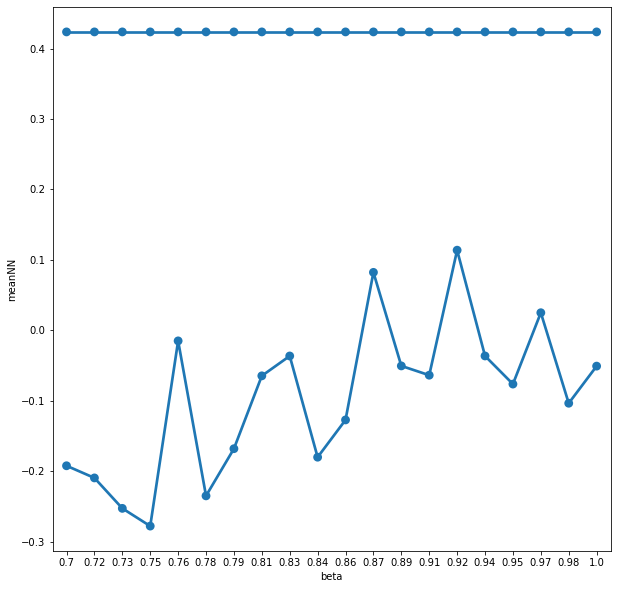

In [266]:
plt.figure(figsize=(10,10))

ax=sns.pointplot('beta','meanNN', data=results,ci=None)
ax=sns.pointplot('beta',0.4236622452735901*torch.ones(len(betas)), data=results,ci=None)
xlabels = np.round(betas,2)
ax.set_xticklabels(xlabels)